# Chapter 6 -- Phase-Retrieval for Optical Pulse Characterization Using FROG

In this chapter we will discuss phase-retrieval for optical pulse characterization.  Due to its ease of implementation and widespread use in the ultrafast community, we will place a particular emphasis on the use of frequency-resolved optical gating (FROG) for phase retrieval.  We will discuss the experimental generation of time-energy spectrograms, how these spectrograms encode both amplitude and phase information, and how to implement a phase-retrieval algorithm to extract phase information from these spectrograms using an appropriate model function.  We will then implement this phase retrieval algorithm and analyze a test spectrogram to demonstrate it in action.  

We note that FROG is just one of many phase-retrieval techniques for the characterization of optical pulses in the time-domain.  This chapter covers basic concepts that can be extended to all phase-retrieval techniques.  Other methods include [SPIDER](https://drive.google.com/file/d/1KrnushsJHzj4I9i7MtKWEKuSvFaomsZ_/view?usp=sharing) and related methods such as [two-dimensional spectral shearing interferometry (2DSI)](https://drive.google.com/file/d/1u9a6EoeMPUMckPnYjKtrB-eZeDcYIVaW/view?usp=sharing).  You are encouraged to read further about these different techniques.  There are subleties and limitations to each of these methods, and you should consider their pros and cons before implementing one of them for your project.  

## Packages, Functions and Variables

The following code-block contains the packages, functions and variables needed for the code found later in this notebook.  It must be run first.  Note that if you are running this on your personal computer, you should ensure that all packages needed are installed first (for example the [numpy](https://numpy.org/), [scipy](https://scipy.org/), and [matplotlib](https://matplotlib.org/) packages must be installed on your computer along with others).  You can find a launcher link at the top to conveniently run this notebook in Google Colab.  

The code below is hidden by default, but you are encouraged to expand it and study it.  The functions and constants will update as needed during the progression of the course, so you should note what new functions have been and added and study how they work.  

**Newly-Added Functions for FROG Analysis**
 - `calc_S_t`
 - `calc_S_f`
 - `project`
 - `next_P`
 - `next_G`

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets
import h5py
from scipy import signal
from scipy.interpolate import UnivariateSpline 

# Import the matplotlib animation tools
# as well as the html tools for creating
# javascript animations
from matplotlib import animation, rc
from IPython.display import HTML

#-- Export Settings --
# If on, then it applies a few tweaks to make sure the export looks good
want_export=False

#--Physical Constants--
hbar = 1.054e-34 #normalized Planck constant [J*s]
evcon = 1.602e-19 #conversion factor, [J/eV]
eta = 119.91699832*np.pi #impedance of freespace [ohms]
me = 9.10938188e-31 #mass of electron [kg]
c = 2.99792458e8 #speed of light [m/s]
e = 1.602e-19 #electron charge [C]

#--Gaussian Pulse Function --
def gaussian_pulse(t, fwhm, wc, phi_ce):
    """
    [E, A] = gaussian_pulse(t, fwhm, wc, phi_ce)

    Function for generating a Gaussian pulse form with given intensity FWHM.
    Outputs electric field profile and intensity envelope, both normalized to
    peak of 1.  Units need to be self-consistent between t, fwhm, and wc.

    Inputs:
    -----------
      t --> time 
      fwhm --> full width at half max of the intensity envelope
      wc --> central frequency (rad/unit time)
      phi_ce --> carrier envelope phase offset (rad)

    Outputs:
    -------------
      pulse['E'] --> Electric field profile (peak of 1)
      pulse['A'] --> Intensity envelope (peak of 1)
    
    """


    #Now determine constant for gaussian envelope from fwhm:
    tau = fwhm/(2*np.sqrt(np.log(2)));

    #Finally, define the pulse:
    E_envelope = np.exp(-t**2/(2*tau**2));
    
    pulse = {}

    pulse['E'] = E_envelope*np.cos(wc*t + phi_ce);

    pulse['A'] = E_envelope**2;
    
    return pulse

#Calculate index based on Sellmeier coefficients
# -- Assumes wavelength in microns
def n_sell(y, B, C):
    """
    Calculate index based on Sellmeier coefficients.
    
    Assumes wavelength y in microns.
    
    B and C should be vectors with equal number of coefficients.
    
    Based on forumlation here: https://en.wikipedia.org/wiki/Sellmeier_equation
    """
    
    n2 = np.ones(y.size)
    
    #We are only concerned with wavelengths > 0!
    y_valid = np.where(y > 0)
    
    for m in range(0, len(B)):
        
        n2[y_valid[0]] = n2[y_valid[0]] + B[m]*y[y_valid[0]]**2/(y[y_valid[0]]**2 - C[m])
        
    n = np.sqrt(np.abs(n2))
    
    return n


def split_step(A0, z, f, dt, beta2, beta3, gamma):
    """
    This function carries out the split step procedure 
    to calculate a pulse spectra propagating through the NLSE. The
    split-step implementation here is not optimized in any way. (I'd say
    that it's relatively inefficient.) This function does not use a
    normalized NLSE. (4-21-20).
    
    INPUTS: 
        A0      sqrt(W):    input pulse
        z       mm:         spatial grid to propagate over (uniformly sampled)
        f       PHz:        frequency span for FFTs (defined by t)
        dt      fs:         temporal spacing 
        beta2   fs^2/mm:    GVD
        beta3   fs^3/mm:    TOD
        gamma   1/(W*mm):   nonlinear coeff.
 
    OUTPUTS:
        A   time signal out
        A_f frequency signal out
    """

    Nz = z.size
    
    #z should be uniformly sampled
    dz = z[1]-z[0]

    # initialize 
    A = np.zeros( (Nz, A0.size)) + 0j
    A_f = np.zeros( (Nz, A0.size) ) + 0j
    A[0, :] = A0
    A_f[0, :] = dt*np.fft.fft(A0);

    #calculate all the traces and spectra
    for co in range(1,Nz):
        #spectrum calculation
        Atemp_f = dt * np.exp(-1j/4*beta2*(2*np.pi*f)**2*dz + 1j/12*beta3*(2*np.pi*f)**3*dz)*\
        np.fft.fft( np.exp(-1j*gamma*np.abs(A[co-1, :])**2*dz)*\
        np.fft.ifft( np.exp(-1j/4*beta2*(2*np.pi*f)**2*dz + 1j/12*beta3*(2*np.pi*f)**3*dz)*\
        np.fft.fft( A[co-1, :] ) ) );

        #assignments
        A_f[co, :] = Atemp_f;
        A[co, :] = 1/dt*np.fft.ifft(Atemp_f);
    
    
    return A, A_f

def active_ml(t, A0, omega_M, M, g, l, omega_g, dT, NT, N_save = 1):
    """
    Calculates the evolution of a seed wave in a resonator with a driven
    loss element to simulate active mode-locking.  This follows the Haus
    master equation as described in H. Haus, “A theory of forced mode locking,” 
    IEEE Journal of Quantum Electronics, vol. 11, no. 7, pp. 323–330, 
    Jul. 1975, doi: 10.1109/JQE.1975.1068636.
    
    All time units below are relative and set by the units of the time
    axis t.
    
    Inputs:
        t         time axis (denotes envelope over time duration of one round trip)
        A0        Initial envelope
        omega_M   Modulation frequency
        M         Modulation strength
        g         Peak gain
        l         loss coefficient (per round trip)
        omega_g   Gain bandwidth (approximated by parabola)
        dT        Step duration (tyically set to T_R, round trip time)
        NT        Number of steps to move forward (round trips if dT=T_R)
        N_save    Number of steps to go before recording the current state of
                  A in the cavity to A_out.

        
    Outputs:
        A_out     Output envelope.  Matrix of floor(NT/N_save) rows, 
                  and length t columns.
        
    """
    dt = t[1] - t[0]
    T_R = t[-1] - t[0]
    
    N_out = int(np.floor(NT/N_save))
    
    A_out = np.zeros((N_out, A0.size)) + 0j
    A_current = A0
    A_out[0, :] = A0
    
    n_out = 0
    for co in range(1, NT):
        
        A_m1 = A_current
        A_m1_pp = np.diff(np.diff(A_m1)/dt)/dt
        A_m1_pp = np.append(A_m1_pp, A_m1_pp[-1])
        A_m1_pp = np.append(A_m1_pp, A_m1_pp[-1])
        
        #Take care to window in frequency -- if you don't high-frequency components can run out of control.
        #These are unphysical and can be ignored.
        A_current = np.fft.ifft(np.fft.fftshift(signal.tukey(t.size, 0.5))*\
                               np.fft.fft((A_m1 + dT*((g - l)*A_m1 + \
                                                      (g/(omega_g**2))*A_m1_pp - \
                                                      M*(1 - np.cos(omega_M*t))*A_m1)/T_R)))
        
        if(np.mod(co, N_save) == 0):
            n_out = n_out + 1
            A_out[n_out, :] = A_current
        
        
    return A_out

def fast_sa_ml(t, A0, g0, W_sat, l, omega_g, s0, I_sat, dT, NT, N_save = 1):
    """
    Calculates the evolution of a seed wave in a resonator with a fast
    saturable absorber element to simulate passive mode-locking.  
    
    All time units below are relative and set by the units of the time
    axis t.
    
    Inputs:
        t         time axis (denotes envelope over time duration of one round trip)
        A0        Initial envelope
        g0        Small-signal gain
        W_sat     Gain saturation energy
        l         loss coefficient (per round trip)
        omega_g   Gain bandwidth (approximated by parabola)
        s0        Unsaturated loss
        I_sat     Saturation intensity
        dT        Step duration (tyically set to T_R, round trip time)
        NT        Number of steps to move forward (round trips if dT=T_R)
        N_save    Number of steps to go before recording the current state of 
                  A in the cavity to A_out.
        
    Outputs:
        A_out     Output envelope.  Matrix of floor(NT/N_save) rows, 
                  and length t columns.
        
    """
    dt = t[1] - t[0]
    T_R = t[-1] - t[0]
    
    N_out = int(np.floor(NT/N_save))
    
    A_out = np.zeros((N_out, A0.size)) + 0j
    A_current = A0
    A_out[0, :] = A0
    
    n_out = 0
    for co in range(1, NT):
        
        A_m1 = A_current
        A_m1_pp = np.diff(np.diff(A_m1)/dt)/dt
        A_m1_pp = np.append(A_m1_pp, A_m1_pp[-1])
        A_m1_pp = np.append(A_m1_pp[0], A_m1_pp)
        
        W_pulse = np.trapz(np.abs(A_m1)**2)*dt
        g = g0/(1 + W_pulse/W_sat)
        
        #Take care to window in frequency -- if you don't high-frequency components can run out of control.
        #These are unphysical and can be ignored.
        A_current = np.fft.ifft(np.fft.fftshift(signal.tukey(t.size, 0.5))*\
                               np.fft.fft((A_m1 + dT*((g - l)*A_m1 + \
                                                      (g/(omega_g**2))*A_m1_pp - \
                                                      (s0/(1 + np.abs(A_m1)**2/I_sat))*A_m1)/T_R)))
        
        if(np.mod(co, N_save) == 0):
            n_out = n_out + 1
            A_out[n_out, :] = A_current
        
        
    return A_out

# -- FROG-Related Functions -- 
    
def calc_S_t(P, G):
    """
    Calcualte the time-domain spectrogram given a pulse and gate.  It is 
    assumed that the delay step size equals the time resolution of the pulse
    and gate.  
    
    Inputs
    -------
    P     Pulse vector of length N
    G     Gate vector of length N + M, where M is the number of delay steps
    
    Outputs
    ---------
    S_t   Time-domain spectrogram (complex)
    """
    
    length_tau = G.size - P.size
    
    S_t = np.zeros((P.size, length_tau)) + 0j
    
    for k in range(0, length_tau):
        
        S_t[:, k] = G[range(k, k + P.size)]*P
        
    return S_t

def calc_S_f(S_t):
    """
    Calcualte the frequqncy-domain spectrogram given the time-domain spectrogram, 
    S_t.  It is assumed that the delay step size equals the time resolution of 
    the pulse and gate.  
    
    Inputs
    -------
    S_t   Time-domain spectrogram (complex) 
    
    Outputs
    ---------
    S_f   Frequency-domain spectrogram (complex)
    """
    
    S_f = np.fft.fftshift(np.fft.fft(S_t, axis=0), axes=(0,))
    
    return S_f

def project(P, G, S_meas):
    """
    Project the calculated phase from a frequency-domain spectrogram generated 
    using P and G onto the measured frequency-domain amplitude spectrogram, S_meas.  
    
    Inputs
    -------
    P       Pulse vector of length N
    G       Gate vector of length N + M, where M is the number of delay steps
    S_meas  Measured frequency-domain spectrogram amplitude (square-root of 
            intensity, real)
    
    Outputs
    ---------
    S_proj  Projected time-domain spectrogram (complex).  
    """
    
    S_proj_f = S_meas*np.exp(1j*np.angle(calc_S_f(calc_S_t(P, G))))
    
    S_proj = np.fft.ifft(np.fft.fftshift(S_proj_f, axes=(0,)), axis=0)
    
    return S_proj
    
def next_P(G, S):
    """
    Generate the next P vector from the current G vector and projected time-domain
    spectrogram S. 
    
    Inputs
    -------
    G     Gate vector of length N + M, where M is the number of delay steps
    S     Projected time-domain spectrogram. 
    
    Outputs
    ---------
    P       Pulse vector of length N 
    """
    
    N = S.shape[0]
    M = S.shape[1]
        
    P = np.zeros((N,)) + 0j
    
    for n in range(0, N):
    
        g_range = range(n, M + n)
        P[n] = np.sum(np.conj(G[g_range])*np.squeeze(S[n, :]))/np.sum(np.abs(G[g_range])**2)
        
    return P
    
    
def next_G(P, S):
    """
    Generate the next G vector from the current P vector and projected time-domain
    spectrogram S. 
    
    Inputs
    -------
    P       Pulse vector of length N 
    S     Projected time-domain spectrogram 
    
    Outputs
    ---------
    G     Gate vector of length N + M, where M is the number of delay steps

    """
    
    N = S.shape[0]
    M = S.shape[1]
    
    K = M + N
    
    G = np.zeros((K,)) + 0j
        
    for k in range(int(N/2), K - int(N/2)):
        
        n_start = np.max([0, k - M+1])
        n_stop = np.min([k+1, N])
        
        n_range = np.flip(np.arange(n_start, n_stop))
        
        m_start = np.max([0, k-N+1])
        m_stop = np.min([k+1, M])
        
        m_range = range(m_start, m_stop)
        
        
        G[k] = np.sum(np.conj(P[n_range])*np.squeeze(S[n_range, m_range]))/np.sum(np.abs(P[n_range])**2)
        
    return G
        
    

## Why Phase Retrieval is Needed

Conventional optical detectors are energy detectors.  The emit an electronic signal that is linearly proportional to the energy incident on them from optical radiation.  This energy of course might fluctuate in time, but there is a limit to how quickly the detector can respond to these changes.  While for nanosecond or even picosecond pulses it is possible to measure the duration of the envelope of an optical pulse directly using a fast detector, such as a diode, this is not possible for femtosecond pulses.  Furthermore, this envelope information is only part of the story.  As you know, the phase of the wave underneath the envelope as a function of time also carries information, such asthe chirp.  To truly understand an optical pulse in both time and frequency requires an undertanding of both the amplitude and the phase of the pulse's envelope.  The central wavelength can of course be deduced from an optical spectrum, so if we know the amplitude and phase distribution of the envelope in time, we then have characterized the complete electromagnetic waveform to within a constant phase (the carrier-envelope phase).  

## A Solution: Frequency-Resolved Optical Gating

Rather than providing a shallow overview of a broad range of techniques for phase retrieval, here we have chosen to provide an in-depth discussion of one technique: Frequency-Resolved Optical Gating (FROG).  While there are many variations of FROG, they all share the following core methods:

 1. Take two pulses (can be the same pulse and its replica) and use them to drive a nonlinear medium where they are spatially overlapped
 2. Extract the spectrum of the nonlinear interaction component (for example the sum frequency component resulting from the interaction of both pulses)
 3. Collect interaction spectra as a function of delay between the two pulses to form a spectrogram

The nonlinear interaction spectrogram theretically contains sufficient information that if fit using a physical model of the nonlinear interaction process, one can fully extract the amplitude and phase profile of both pulses.  

To better visualize why this works, consider the case of two pulses.  One is very short and transform-limited.  We will call this the gate with envelope $G(t)$.  Then take a pulse that is longer and not transform-limited.  We will call this the pulse with complex envelope $P(t)$. We then perform sum-frequency generation between the two pulses with a variable delay in time between the two.  The complex sum-frequency spectrogram then takes the form:

$$S(\omega, \tau) = \int_{-\infty}^{\infty} \mathrm{d}t P(t - \tau) G(t) e^{j\omega t}$$

It is important to note that what is measured in experiment is not $S$ but rather the intensity spectrogram $I(\omega, \tau) = |S(\omega, \tau)|^2$. 

If $G(t)$ is very short compared to $P(t)$ then over the duration of $G(t)$, $P(t)$ can be approximated as $P_0(\tau) \exp \big \lbrace j \left [ \varphi_1(\tau) t + \varphi_0(\tau) \right ] \big \rbrace$ where $P_0(\tau)$ is the amplitude of $P(t)$ at $\tau$, $\varphi_1(\tau)$ is the local frequency offset of $P(t)$ relative to the central frequency at $\tau$, and $\varphi_0(\tau)$ the local phase offset at $\tau$.  Then the central wavelength of the sum frequency spectrum will shift as a function of delay according to the freuqency offset of $P(t)$ as it scans through it.  This central wavelength shift then can be mapped to $\varphi_1$, which is related the derivative of the phase of $P(t)$ in time.  This is certainly an oversimplification, but gives a solid idea of how the spectrogram contains phase information about the pulse (and in general botht he pulse and gate).       

We can show a couple of examples that hopefully make this a bit clearer.  

Below we create two Gaussian pulses, with $G(t)$ being 10 femtoseconds long and transorm-limited, and $P(t)$ being 30 fs long and also transform-limited.  We can calculate the spectrogram as shown above and plot it.  

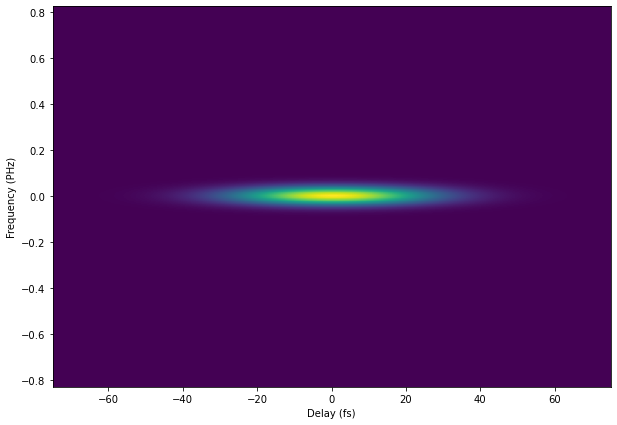

In [12]:
#Set up the time-axes for the pulse and gate
# -- they need to be the same resolution
# -- delay length set by the difference between the gate size and pulse size
t_P = np.linspace(-75, 75, 250)
t_G = np.linspace(-150, 150, 500)

dt = t_P[1] - t_P[0]
f = np.fft.fftshift(np.fft.fftfreq(t_P.size, dt))

T_D = t_G[-1] - t_P[-1]
extent = [-T_D, T_D, f[0], f[-1]]

dt = t_P[1] - t_P[0]
f = np.fft.fftshift(np.fft.fftfreq(t_P.size, dt))

#Now for the initial duration of the pulse and gate envelopes
fwhm_P = 30
fwhm_G = 10

#Use our convenience gaussian_pulse function to create the pulse and gate envelopes.
# -- For the pulse, some non-trivial phase profile for this demonstration
P_pulse = gaussian_pulse(t_P, fwhm_P, 0, 0)
P = np.sqrt(P_pulse['A'])

G_pulse = gaussian_pulse(t_G, fwhm_G, 0, 0)
G = np.sqrt(G_pulse['A'])

#Calculate the measured frequency spectrogram (amplitude, all real)
S_meas = np.abs(calc_S_f(calc_S_t(P, G)))

fig = plt.figure()
fig.set_size_inches(10, 7)

plt.imshow(np.flipud(S_meas), extent=extent, aspect='auto')
plt.xlabel('Delay (fs)')
plt.ylabel('Frequency (PHz)')
plt.show()

Note that the sum-frequency spectrogram takes on a flat disk-shape.  This is indicative of a transform-limited FROG spectrogram.  

Next, we can add some quadratic phase (linear chirp) to $P$.  

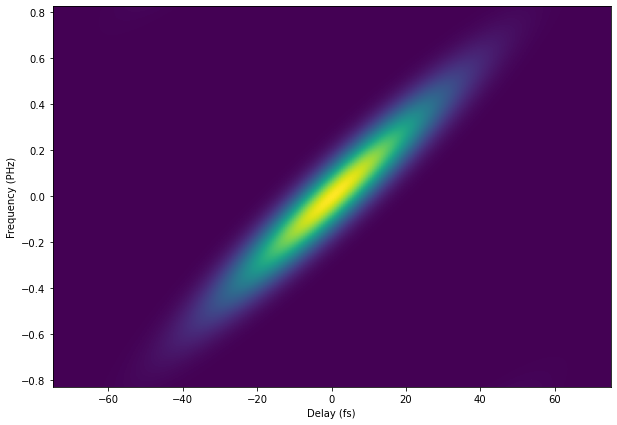

In [13]:
#Set up the time-axes for the pulse and gate
# -- they need to be the same resolution
# -- delay length set by the difference between the gate size and pulse size
t_P = np.linspace(-75, 75, 250)
t_G = np.linspace(-150, 150, 500)

#Now for the initial duration of the pulse and gate envelopes
fwhm_P = 30
fwhm_G = 10

#Use our convenience gaussian_pulse function to create the pulse and gate envelopes.
# -- For the pulse, some non-trivial phase profile for this demonstration
P_pulse = gaussian_pulse(t_P, fwhm_P, 0, 0)
P = np.sqrt(P_pulse['A'])*np.exp(-0.05*1j*t_P**2)

G_pulse = gaussian_pulse(t_G, fwhm_G, 0, 0)
G = np.sqrt(G_pulse['A'])

#Calculate the measured frequency spectrogram (amplitude, all real)
S_meas = np.abs(calc_S_f(calc_S_t(P, G)))

fig = plt.figure()
fig.set_size_inches(10, 7)

plt.imshow(np.flipud(S_meas), extent=extent, aspect='auto')
plt.xlabel('Delay (fs)')
plt.ylabel('Frequency (PHz)')
plt.show()

We can then see that the central frequency of the sum-frequency decreases linearly as a function of delay, indicating a negative chirp, which is precisely what we imprinted on $P(t)$ here.  This is a general trend when using a short, compressed gate along with a longer uncompressed pulse.  The shape traced out by the central frequency of the sum-frequency peak takes on a form related to the slope of the phase in time (corresponding to the offset in the local frequency probed by the gate).  

What if we switch to a positive chirp (i.e. positive quadratic phase)?  

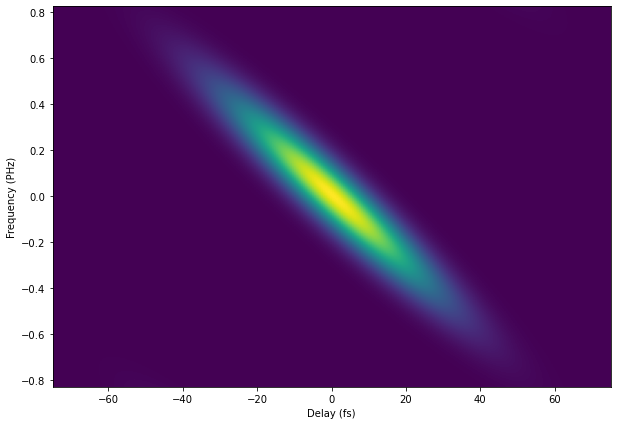

In [14]:
#Set up the time-axes for the pulse and gate
# -- they need to be the same resolution
# -- delay length set by the difference between the gate size and pulse size
t_P = np.linspace(-75, 75, 250)
t_G = np.linspace(-150, 150, 500)

#Now for the initial duration of the pulse and gate envelopes
fwhm_P = 30
fwhm_G = 10

#Use our convenience gaussian_pulse function to create the pulse and gate envelopes.
# -- For the pulse, some non-trivial phase profile for this demonstration
P_pulse = gaussian_pulse(t_P, fwhm_P, 0, 0)
P = np.sqrt(P_pulse['A'])*np.exp(0.05*1j*t_P**2)

G_pulse = gaussian_pulse(t_G, fwhm_G, 0, 0)
G = np.sqrt(G_pulse['A'])

#Calculate the measured frequency spectrogram (amplitude, all real)
S_meas = np.abs(calc_S_f(calc_S_t(P, G)))

fig = plt.figure()
fig.set_size_inches(10, 7)

plt.imshow(np.flipud(S_meas), extent=extent, aspect='auto')
plt.xlabel('Delay (fs)')
plt.ylabel('Frequency (PHz)')
plt.show()

It is the same, but now the central frequency increases linearly as a function of delay.  

For fun, we can also apply a third-order polynomial phase in time, and as expected this leads to a quadratic shift in sum-frequency output.

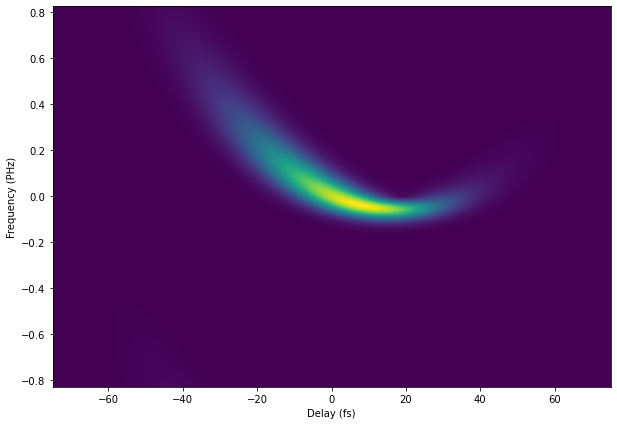

In [15]:
#Set up the time-axes for the pulse and gate
# -- they need to be the same resolution
# -- delay length set by the difference between the gate size and pulse size
t_P = np.linspace(-75, 75, 250)
t_G = np.linspace(-150, 150, 500)

#Now for the initial duration of the pulse and gate envelopes
fwhm_P = 30
fwhm_G = 10

#Use our convenience gaussian_pulse function to create the pulse and gate envelopes.
# -- For the pulse, some non-trivial phase profile for this demonstration
P_pulse = gaussian_pulse(t_P, fwhm_P, 0, 0)
P = np.sqrt(P_pulse['A'])*np.exp(0.025*1j*t_P**2 + .0005*1j*t_P**3)

G_pulse = gaussian_pulse(t_G, fwhm_G, 0, 0)
G = np.sqrt(G_pulse['A'])

#Calculate the measured frequency spectrogram (amplitude, all real)
S_meas = np.abs(calc_S_f(calc_S_t(P, G)))

fig = plt.figure()
fig.set_size_inches(10, 7)

plt.imshow(np.flipud(S_meas), extent=extent, aspect='auto')
plt.xlabel('Delay (fs)')
plt.ylabel('Frequency (PHz)')

plt.show()

While this is instructive, in practice it is difficult to produce a short enough gate pulse to so easily extract such information visually.  In fact, one often is using the same pulse to measure itself.  Furthermore, even in these examples, there is a complex convolution process when the gate pulse is either not much shorter than $P(t)$ or is itself not transform-limited.  To quantitatively extract the full phase information, even for cases where both $P(t)$ and $G(t)$ are unknown, one needs to use a phase-retrieval algorithm. This exploits the true power of FROG to analyze a seemingly complex spectrogram that would otherwise be intractable to the human eye.  

## Constructing a Phase-Retrieval Algorithm for FROG Analysis

The most common phase-retrieval algorithm for FROG is the Principal Components Generalized Projections Algorithm (PCGPA).  One of the better references that explains this approach quite clearly is that of [Kane et al.](https://drive.google.com/file/d/1CBrbo7WnygH6pRvj4ohZQlPFb73n6nBp/view?usp=sharing)  Note that this paper includes a fully functional MATLAB script at the end for performing the phase retrieval.  While the PCGPA approach is quite elegant, it is not the only approach.  Here we will develop and use a [Least-Squares](https://drive.google.com/file/d/1byr-Qrosi_wYs1mA24amZ4Tl3b9JpQIP/view?usp=sharing) approach which requires less knowledge of linear algebra and directly demonstrates retrieval by minimization of a cost function defined as the cumulative squared error between the retrieved and measured spectrograms. 

First of all, rather than working in the frequency domain, we can choose to work in the time-domain.  From here on out, we will define $\tilde{S}(\omega, \tau)$ as the frequency-domain spectrogram and $S(t, \tau)$ as the time-domain spectrogram.  Note that $S(t, \tau) = P(t-\tau)G(t)$.  We then can discretize the system for calculation as $S[n, m] = P[n]G[n + m]$, with $n$ representing the sample number in time, and $m$ being the sample number in delay.

So now we have a way to convert from a discretized pulse $P[n]$ and gate $G[n]$.  The second step is to then develop a cost function that compares this to the information in the measured spectrogram.  This is where the "projection" part comes into play (hence why this class of algorithms are called generalized projection algorithms).  What we can do is the following:

 1. Use the current estimate for $P$ and $G$ to calculate the time-domain spectorgram $S$
 2. Perform a Fourier transform along the time-dimension of $S$ to calculate $\tilde{S}$
 3. The measured spectrogram is an intensity spectrogram $I(\omega, \tau)$.  Extract the amplitude from this and project it onto $\tilde{S}'$ such that $\tilde{S}' = \sqrt{I}\tilde{S}/|\tilde{S}|$
 4. Inverse Fourier-transform $\tilde{S}'$ to obtain $S'$
 5. Define the cost function as $M = \sum_{m} \sum_{n} |S - S'|^2 = \sum_{m} \sum_{n} (P[n]G[n + m] - S'[n, m])\times \mathrm{c.c.}$
 
So now we have a metric defining the error that depends on both the measured intensity spectrogram as well as $P$ and $G$.  We now simply need to find what values for all of $P[n]$ and $G[n]$ minimize this cost function.  On approach is to minimize the cost function for each term in $P$ and $G$ individually and iteratively.  For instance, consider what the next value should be for $P[n]$ to minimize the cost function.  To do this, we can simply take the derivative of $M$ with respect to $P[n]$ and set it equal to zero.  This becomes the following:

$$\frac{\partial M}{\partial P[n]} = \sum_m G[n + m](P[n]^*G[n + m]^* - S'[n, m]^*) + G[ n + m]^*(P[n]G[n + m] - S'[n, m]) = 0$$

Note that the two terms in the summation are simply complex conjugates of one another.  Thus, if their sum is always zero then they both must be zero.  This simplifies to the following requirement

$$\sum_m G[ n + m]^*(P[n]G[n + m] - S'[n, m]) = 0$$

We can then solve for $P[n]$

$$P[n] = \bigg ( \sum_m G[n + m]^* S'[n, m] \bigg ) \bigg / \bigg ( \sum_m |G[n + m]|^2 \bigg )$$

It is left as an exercise to show that 

$$G[k] = \bigg ( \sum_m P[k - m]^* S'[k - m, m] \bigg ) \bigg / \bigg ( \sum_m |P[k - m]|^2 \bigg )$$

Note that one has to take care in these summations as these pulses are not defined for over infinite time.  We take that $G$ is of length $N$ + $M$ where $N$ is the number of points in the pulse, and $M$ is the number of delay steps.  The solution for $P$ is then rather straightforward, but the bounds over $m$ for the solution of $G$ cannot be such that one uses data outside of the allowed window of $P$, or such that one divides by $0$.  We can achieve this by: 

 1. Ignoring the first and last $\lfloor N/2 \rfloor$ points in $G$ by setting these points to 0, and 
 2. Making sure that $m$ is always chosen such that $k - m \in [0, N)$.  See the implementation of the function `next_G` in the header code for this recitation for details on how this is implemented.  

Note that now we have a complete recipe for iteratively retrieving $P$ and $G$.  We first take our current guess for both, then we perform a project step to get an updated $S'$, and finally we develop the next guess for $P$ and $G$ via the summations just described.  We can use the project step at any point, but typically a single iteration that works quite well is (1) project, (2) calculate $P$, (3) project (4) calculate $G$, back to (1).  

In the following we use this technique to demonstrate phase retrieval.  

## Example Phase Retrieval Using the Least-Squares Approach

We start by setting up the system.  We create a pulse and gate and use those to calculate an intensity spectrogram in the frequency domain `I_meas_f` that will serve as our proxy to the measured spectrogram.  We will then perform the least squares projection algorithm as described in the previous section to this measured spectrogram to retrieve both $P$ and $G$ which we can compare to the starting values to test the quality of our retrieval.  

In [16]:
#Set up the time-axes for the pulse and gate
# -- they need to be the same resolution
# -- delay length set by the difference between the gate size and pulse size
t_P = np.linspace(-75, 75, 250)
t_G = np.linspace(-150, 150, 500)

dt = t_P[1] - t_P[0]
f = np.fft.fftshift(np.fft.fftfreq(t_P.size, dt))

#Now for the initial duration of the pulse and gate envelopes
fwhm_P = 20
fwhm_G = 15

#Use our convenience gaussian_pulse function to create the pulse and gate envelopes.
# -- For the pulse, some non-trivial phase profile for this demonstration
P_pulse = gaussian_pulse(t_P, fwhm_P, 0, 0)
P = np.sqrt(P_pulse['A'])*np.exp(-0.05*1j*t_P**2 +.0005*1j*t_P**3 + .00005*1j*t_P**4)

G_pulse = gaussian_pulse(t_G, fwhm_G, 0, 0)
G = np.sqrt(G_pulse['A'])*np.exp(0.025*1j*t_G**2)

#Calculate the measured frequency spectrogram (amplitude, all real)
I_meas_f = np.abs(calc_S_f(calc_S_t(P, G)))**2


Next we run the leas squares algorithm for a set number of iterations to develop a retrieve pulse and gate.  For visualization we collect a number of the pulse outputs and spectrograms as the minimization progresses to create a video of the process.  It's illustrative to examine the code below, especially inside the `for` loop, to understand how the retrieval algorithm proceeds on each iteration.  

In [17]:
#Now we need to make an initial guess for the pulse and gate... 
P_guess = np.sqrt(gaussian_pulse(t_P, 20, 0, 0)['A'])
G_guess = np.sqrt(gaussian_pulse(t_G, 20, 0, 0)['A'])

#We now load these guesses into the starting pulse and gate
# -- these are the current pulse and gate
# -- they are updated on each iteration of the algorithm
P_cur = P_guess + 0j
G_cur = G_guess + 0j

S_proj = np.zeros(S_meas.shape)
S_proj = project(P_cur, G_cur, S_meas)

calc_S_t(P_cur, G_cur).shape

iter = 300
frames = 51

M = np.zeros((iter, ))

#Arrays for storing outputs for plotting/animations below
I_out = np.zeros((S_proj.shape[0], S_proj.shape[1], frames))
I_out[:, :, 0] = np.abs(calc_S_f(calc_S_t(P_cur, G_cur)))**2
P_out = np.zeros((P_cur.shape[0], frames)) + 0j
P_out[:, 0] = P_cur
G_out = np.zeros((G_cur.shape[0], frames)) + 0j
G_out[:, 0] = G_cur

n_frame = 0
for i in range(0, iter):
    
    S_proj = project(P_cur, G_cur, np.sqrt(I_meas_f))
    P_cur = next_P(G_cur, S_proj)
    P_cur = P_cur/np.max(np.abs(P_cur))

    S_proj = project(P_cur, G_cur, np.sqrt(I_meas_f))
    G_cur = next_G(P_cur, S_proj)
    
    M[i] = np.sum(np.sum((np.abs(calc_S_t(P_cur, G_cur) - project(P_cur, G_cur, np.sqrt(I_meas_f)))**2)))
    
    if (np.mod(i + 1, iter/(frames - 1)) == 0):
        
        n_frame = n_frame + 1
        
        I_out[:, :, n_frame] = np.abs(calc_S_f(calc_S_t(P_cur, G_cur)))**2
        P_out[:, n_frame] = P_cur
        G_out[:, n_frame] = G_cur
        
    #print(i)

In [18]:
fig = plt.figure()
fig.set_size_inches(15, 10)

T_D = t_G[-1] - t_P[-1]
extent = [-T_D, T_D, f[0], f[-1]]


ax1 = fig.add_subplot(2, 2, 1)
ax1.imshow(np.flipud(I_meas_f/np.max(np.max(I_meas_f))), 
           extent=extent, aspect='auto')
ax1.set_xlim(-40, 40)
ax1.set_ylim(-0.4, 0.4)
ax1.set_xlabel('Delay (fs)')
ax1.set_ylabel('Frequency (PHz)')
ax1.set_title('Measured Spectrogram')

ax2 = fig.add_subplot(2, 2, 2)
im = ax2.imshow(np.flipud(I_out[:, :, 0].squeeze()/np.max(np.max(I_out[:, :, 0]))),
               extent=extent, aspect='auto')
ax2.set_xlim(-40, 40)
ax2.set_ylim(-0.4, 0.4)
ax2.set_xlabel('Delay (fs)')
ax2.set_ylabel('Frequency (PHz)')
ax2.set_title('Retrieved Spectrogram')

ax3 = fig.add_subplot(2, 2, 3)
t_shift = -0.0
line1, = ax3.plot(t_G, np.abs(G_out[:, 0])**2, 'x', label='G_cur')
line2, = ax3.plot(t_P, np.abs(P_out[:, 0])**2, 'o', label='P_cur')
ax3.plot(t_P+ t_shift, np.abs(P)**2, label='P', color='tab:orange')
ax3.plot(t_G + t_shift, np.abs(G)**2, label='G', color='tab:blue')
ax3.set_xlim(-40, 40)
ax3.legend(loc='upper left')
ax3.set_xlabel('Time (fs)')
ax3.set_ylabel('Intensity (arb. units)')
ax3.set_title('Retrieved Amplitudes')

ax4 = fig.add_subplot(2, 2, 4)
line3, = ax4.plot(t_G[0:-1], np.diff(np.unwrap(np.angle(G_out[:, 0]))), 'x', label='G_cur', alpha=0.5)
line4, = ax4.plot(t_P[0:-1], np.diff(np.unwrap(np.angle(P_out[:, 0]))), 'o', label='P_cur', alpha=0.5)
ax4.plot(t_G[0:-1] + t_shift, np.diff(np.unwrap(np.angle(G))), label='G', color='tab:blue')
ax4.plot(t_P[0:-1] + t_shift, np.diff(np.unwrap(np.angle(P))), label='P', color='tab:orange')
ax4.set_xlim(-30, 30)
ax4.legend(loc='upper left')
ax4.set_xlabel('Time (fs)')
ax4.set_ylabel(r'd$\varphi$/d$t$ (rad/s)')
ax4.set_title('Retrieved Phases')

def updatefig(i):
    
    im.set_array(np.flipud(I_out[:, :, i].squeeze()/np.max(np.max(I_out[:, :, i]))))
    
    line1.set_data(t_G, np.abs(G_out[:, i].squeeze())**2)
    line2.set_data(t_P, np.abs(P_out[:, i].squeeze())**2)
                                                
    line3.set_data(t_G[0:-1], np.diff(np.unwrap(np.angle(G_out[:, i]))))
    line4.set_data(t_P[0:-1], np.diff(np.unwrap(np.angle(P_out[:, i]))))
    
    ax2.set_title('Retrieved Spectrogram: ' + str(i*iter/(frames - 1)) + ' iterations')
                                            
    
    return im, line1, line2, line3, line4

#Setup the animation
ani = animation.FuncAnimation(fig, updatefig, interval=200, frames=frames, blit=True)

#Convert to javascript html movie
html = HTML(ani.to_jshtml())

#Display the movie, and close the figure so we only have the animation
display(html)
plt.close() # update

Now, lets compare the retrieved and measured spectrograms. 

As you can see, the retrieval is already nearly perfect after 200 iterations.  We can further see the quality of the fit by plotting the cumulative squared error $M$ as a function of iteration.  

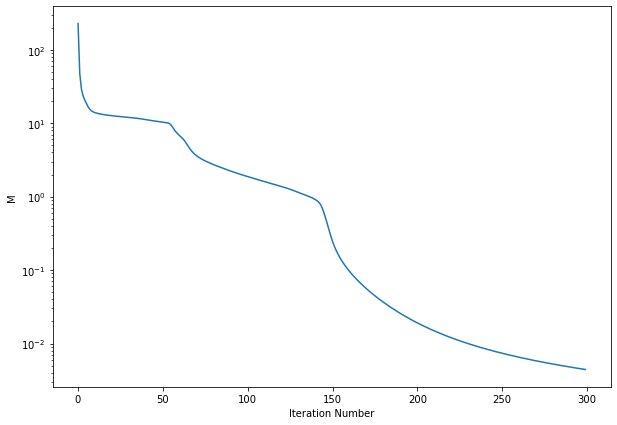

In [19]:
fig = plt.figure()
fig.set_size_inches(10, 7)

plt.semilogy(M)
plt.xlabel('Iteration Number')
plt.ylabel('M')
plt.show()

There are a few plateaus followed by sudden improvements in the fit.  We have empirically demonstrated convergence by comparison to the known ground truth here, but note that in experimental situations one has to take care as the ground truth is not actually known apriori.  Typically, convergence criteria and various sanity checks are used.  Regarding convergence, one can check that the percent change in M on each iteration is below a pre-chosen value that is sufficiently small.  This still does not guarantee, however, that you have not entered alocal minimum.  To prevent this, one can check that the algorithm converges to the same solution upon using differently initial seed pulses.  Finally, it is possible to compare the retrieved pulse spectra to separate measuremetns of the individual pulse spectra before nonlinear interaction.  